<a href="https://colab.research.google.com/github/amirebm/ML-Implementation/blob/master/integrated_gradient_titanic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pytorch-lightning --quiet
! pip install captum
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00
Mounted at /content/drive


In [6]:
# Our ML things
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset

from captum.attr import IntegratedGradients
from pytorch_lightning import seed_everything
from pytorch_lightning import Trainer
# Visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Utils
from enum import Enum
from sklearn.metrics import classification_report


df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic-dataset/Titanic.csv')
df



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
0,1,3,Allison Hill,male,17,4,2,43d75413-a939-4bd1-a516-b0d47d3572cc,144.08,Q,1
1,2,1,Noah Rhodes,male,60,2,2,6334fa2a-8b4b-47e7-a451-5ae01754bf08,249.04,S,0
2,3,3,Angie Henderson,male,64,0,0,61a66444-e2af-4629-9efb-336e2f546033,50.31,Q,1
3,4,3,Daniel Wagner,male,35,4,0,0b6c03c8-721e-4419-afc3-e6495e911b91,235.20,C,1
4,5,1,Cristian Santos,female,70,0,3,436e3c49-770e-49db-b092-d40143675d58,160.17,C,1
...,...,...,...,...,...,...,...,...,...,...,...
995,996,2,Brittany Ward,male,69,2,3,75eb0e8f-a090-460d-a7c7-655a7b434a72,19.87,Q,1
996,997,2,Edward Stanley,female,61,4,4,e55b93ad-8976-4471-9d7f-57d1e45def26,85.35,C,0
997,998,3,Christina Johnson,male,10,4,1,d06d3943-c8b3-415e-b664-704355c9bf0f,444.22,C,0
998,999,3,Edgar Miller,male,50,3,2,0e5779ec-be1a-470f-ad83-a4c869f8d3e4,234.67,S,1


In [27]:
# Simple enum that helps organizing
# Not really important
class TrainType(Enum):
    train = 1
    test = 2


# Our Custom Dataset class
class RMSTitanic(Dataset):
   def __init__(self, type: TrainType):

     df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic-dataset/Titanic.csv')
     # Select relevant fields
     df = df[['Survived', 'Pclass',
                 "Sex", "Age", "SibSp",
                 "Fare"]]
        # Convert Sex -> 0/1
     m = {'male': 1, 'female': 0}
     df['Sex'] = df[
            'Sex'].str.lower().map(m)
        # Fix the non available vals
        # Also normalize
     df = df.fillna(df.median())
     df -= df.min()
     df /= df.max()
        # The first 80% are Train
     if type == TrainType.train:
        self.df = df.loc[:int(
                0.8 * len(df))]
     if type == TrainType.test:
        self.df = df.loc[int(
                0.8 * len(df)):]
        # We will use this later for interpretation
     self.base = torch.tensor(df[
                                     [
                                         'Pclass',
                                         "Sex",
                                         "Age",
                                         "SibSp",
                                         "Fare"]
                                 ].mean()).float()

   def __len__(self):
        return len(self.df)

   def __getitem__(self, item):
        # This function return the i-th elem
        row = self.df.iloc[item]
        label = row['Survived']
        features = row[['Pclass', "Sex",
                        "Age", "SibSp",
                        "Fare"]]
        # return the (label,features)
        return (
            torch.tensor(
                features).float(),
            torch.tensor(
                label).float()
        )

In [28]:



class MyHeartWillGoOn(
    pl.LightningModule):

    def __init__(self):
        # Setting up our model
        super().__init__()
        # way to fancy model
        self.lr = 0.01
        self.batch_size = 512
        l1 = 128

        # We send our 5 features into first layer
        self.input = torch.nn.Linear(5,
                                     l1)
        # PRELU is just a fancy activation function
        self.r1 = torch.nn.PReLU()
        # More Layers
        self.l1 = torch.nn.Linear(l1,
                                  l1)
        self.r2 = torch.nn.PReLU()
        self.out = torch.nn.Linear(l1,
                                   1)
        # Befor the Output use a sigmoid
        self.sigmoid = torch.nn.Sigmoid()
        # Define loss
        self.criterion = torch.nn.BCELoss()

    def forward(self, x):
        # Heart of our model
        x = self.input(x)
        x = self.l1(x)
        x = self.r1(x)
        x = self.out(x)
        x = self.r2(x)
        x = self.sigmoid(x)

        return x

    def train_dataloader(self):
        # Load our Dataset: TRAIN
        return DataLoader(
            RMSTitanic(
                type=TrainType.train),
            batch_size=self.batch_size,
            shuffle=True)

    def val_dataloader(self):
        # Load our Dataset: TEST
        # Simplification: TEST=VAL
        return DataLoader(
            RMSTitanic(
                type=TrainType.test),
            batch_size=self.batch_size,
            shuffle=False)

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.lr)

    def training_step(self, batch,
                      batch_idx):
        # Here we just log some basics
        # We can look at them later in tensorboard
        x, y = batch
        y_hat = self(x)
        y = torch.reshape(y, (
            y.size()[0], 1))
        loss = self.criterion(y_hat, y)
        tensorboard_logs = {
            'loss': loss}
        return {'loss': loss,
                'log': tensorboard_logs}

In [37]:
if __name__ == '__main__':
    to_be_df = []
    max_epoch = 20
    # Seed so we can reproduce
    seed_everything(404)
    # Load model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MyHeartWillGoOn().to(device)
    # Make the Trainer do the work
    trainer = Trainer(max_epochs=max_epoch,
                      min_epochs=1,
                      enable_progress_bar=True)
    # Tune the learning rate if needed

    trainer.fit(model)
    # Accuracy #ToBeMeasured
    ts = RMSTitanic(TrainType.test)
    # Bit of Hacking
    x = torch.stack(
        [ts.__getitem__(i)[0] for i in
         range(ts.__len__())]
    )
    y = torch.stack(
        [ts.__getitem__(i)[1] for i in
         range(ts.__len__())]
    ).cpu().detach().numpy()
    y_hat = model.forward(
        x).cpu().detach().numpy()
    y_hat = (y_hat > 0.5)
    # Accuracy and other metrics
    print("REPORTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT:\n",
          classification_report(y,
                                y_hat))


INFO:lightning_fabric.utilities.seed:Seed set to 404
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | input     | Linear  | 768    | train
1 | r1        | PReLU   | 1      | train
2 | l1        | Linear  | 16.5 K | train
3 | r2        | PReLU   | 1      | train
4 | out       | Linear  | 129    | train
5 | sigmoid   | Sigmoid | 0      | train
6 | criterion | BCELoss | 0      | train
----------------------------------------------
17.4 K    Trainable params
0         Non-trainable params

Training: |          | 0/? [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating ke

REPORTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT:
               precision    recall  f1-score   support

         0.0       0.49      0.75      0.60       102
         1.0       0.43      0.19      0.27        98

    accuracy                           0.48       200
   macro avg       0.46      0.47      0.43       200
weighted avg       0.46      0.48      0.44       200



<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wi

<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(


IN X1: tensor([1.0000, 1.0000, 0.3462, 0.0000, 0.7640])
IMPORTANCE X_mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm: tensor([ 0.0092,  0.0161,  0.0101, -0.0356, -0.0048], dtype=torch.float64)
Probability SURVIVAl X_m: tensor([[0.4742]], grad_fn=<ViewBackward0>)
Let's Change the gender ->X2
IMPORTANCE X_ffffffffffffffffffffffffffffffffffffffff: tensor([ 0.0103, -0.0214,  0.0117, -0.0373, -0.0060], dtype=torch.float64)
Probability SURVIVAl  X_f: tensor([[0.4365]], grad_fn=<ViewBackward0>)


<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  torch.tensor(
<ipython-input-27-54b57417e1ec>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wi

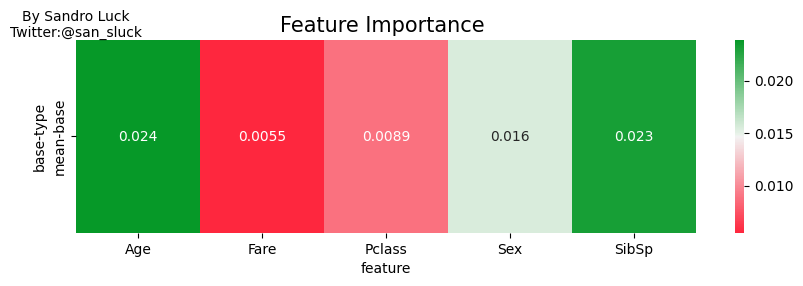

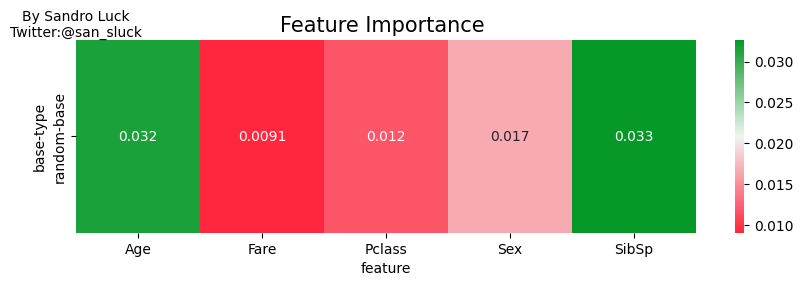

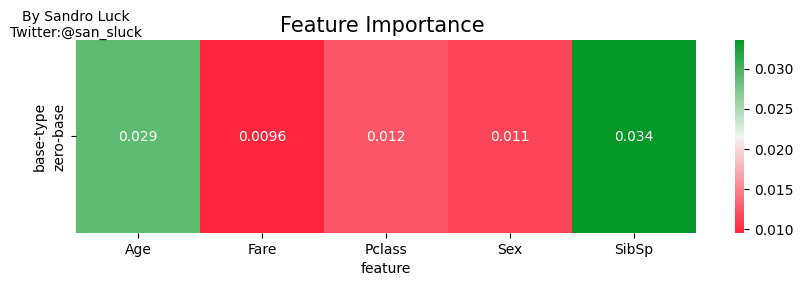

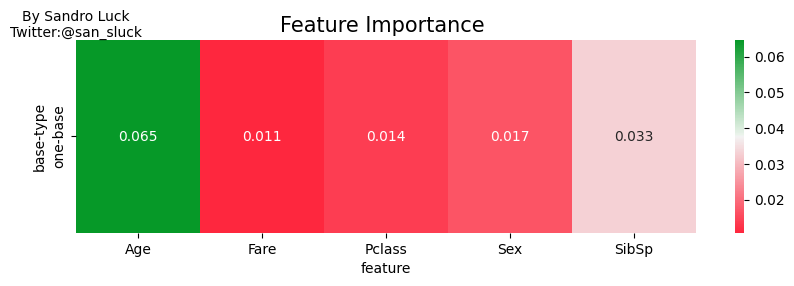

In [38]:

    # Let's start with the interpretation
    STEP_AMOUNT = 50
    SAMPLE_DIM = 5
    # Since Captum is not directly
    # made for Lightning,
    # we need this wrapper
    def modified_f(in_vec):
        # Changes the shapes correctly
        # X:Shape([SAMPLE_DIM*STEP_AMOUNT]=250)
        x = torch.reshape(in_vec,
                          (int(
                              in_vec.size()[
                                  0] / SAMPLE_DIM),
                           SAMPLE_DIM)
                          )
        # RES:Shape([50,5])
        # Since we have 50ti Batches and 5 features
        res = model.forward(x)
        # Again reshape to correct dims
        res = torch.reshape(res, (
            res.size()[0], 1))
        return res


    ig = IntegratedGradients(modified_f)
    # Test to understand the basics
    # First get the 6th test example
    val = ts.__getitem__(6)[0]
    print("IN X1:", val)
    # Predict the importance of the features
    # for the male example
    imp_m = ig.attribute(inputs=val,
                         baselines=ts.base,
                         n_steps=STEP_AMOUNT)
    print("IMPORTANCE X_mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm:", imp_m)
    print("Probability SURVIVAl X_m:",
          modified_f(val))
    # Predict the importance of the features
    # for the female example
    print(
        "Let's Change the gender ->X2")
    val_f = val
    val_f[1] = 0
    imp_f = ig.attribute(inputs=val_f,
                         baselines=ts.base,
                         n_steps=STEP_AMOUNT)
    print("IMPORTANCE X_ffffffffffffffffffffffffffffffffffffffff:", imp_f)
    print("Probability SURVIVAl  X_f:",
          modified_f(val_f))
    # Compare each element of the test set to out baselines
    # we will than use this
    for i in range(0,
                   ts.__len__()):
        # load our test example
        in_val = ts.__getitem__(i)[0]
        # compare it to the 4 baselines
        att_b = ig.attribute(
            inputs=in_val,
            baselines=ts.base,
            n_steps=STEP_AMOUNT).abs().detach().cpu().numpy()
        att_r = ig.attribute(
            inputs=in_val,
            baselines=torch.rand(
                5),
            n_steps=STEP_AMOUNT).abs().detach().cpu().numpy()
        att_z = ig.attribute(
            inputs=in_val,
            baselines=torch.zeros(
                5),
            n_steps=STEP_AMOUNT).abs().detach().cpu().numpy()
        att_1 = ig.attribute(
            inputs=in_val,
            baselines=torch.ones(
                5),
            n_steps=STEP_AMOUNT).abs().detach().cpu().numpy()
        # save result, this will produce a df
        # you can skip the details
        for base_type, vals in [
            ("mean-base", att_b),
            ("random-base", att_r),
            ("zero-base", att_z),
            ('one-base', att_1),
        ]:
            for i, name in enumerate(['Pclass',
                                      "Sex",
                                      "Age",
                                      "SibSp",
                                      "Fare"]):
                to_be_df.append({
                    "base-type": base_type,
                    "feature": name,
                    "value": vals[i],
                    "epoch": max_epoch
                })
    df = pd.DataFrame(to_be_df)
    df.to_csv('/content/drive/My Drive/Colab Notebooks/titanic-dataset/interpretation_results.csv') # Specify a file name, like 'interpretation_results.csv' within the directory
    # Aggregate and Visualize
    # Load Data
    df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/titanic-dataset/interpretation_results.csv')
    # Defined the color map for our heatmap to be red to green
    cmap = sns.diverging_palette(h_neg=10, h_pos=130, s=99,
                                 l=55, sep=3, as_cmap=True)
    # Aggregate the CSV by mean
    df = df.groupby(["base-type", 'feature', 'epoch'],
                    as_index=False).mean()
    df = df[df['epoch'] == max_epoch]
    # Make one plot per baseline to compare
    for b in ["mean-base",
              "random-base",
              "zero-base",
              'one-base']:
        # Create a pivot frame
        tmp = df[df['base-type'] == b]
        tmp = tmp.pivot(index='base-type',
                        columns='feature',
                        values='value')
        # Some code to make a heatmap using seaborn
        fig, ax = plt.subplots()
        fig.set_size_inches(10, 2.5)

        plt.title("Feature Importance ", fontsize=15)
        sns.heatmap(tmp, ax=ax, cmap=cmap, annot=True)
        plt.text(0, 0,
                 'By Sandro Luck\nTwitter:@san_sluck',
                 horizontalalignment='center',
                 verticalalignment='bottom',
                 fontsize=10)

      #  plt.savefig(f'data/{b}.png')
